<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

Импорт необходимых библиотек

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [25]:
t = dataset['train']['text'][0]
t

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [31]:
a = sent_tokenize(t)[0]
a

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.'

In [32]:
word_tokenize(a)

['I',
 'rented',
 'I',
 'AM',
 'CURIOUS-YELLOW',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

In [33]:
sent_list = sent_tokenize(t)[0:2]
word_list = [word_tokenize(i.lower()) for i in sent_list]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [251]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for text in tqdm(dataset['train']['text']):
  sent_list = sent_tokenize(text)
  word_list = [word_tokenize(i.lower()) for i in sent_list]
  sentences.extend(
      [x for x in word_list if len(x) < word_threshold]
      )
# sentences - список предложений, где каждое предложение это список из слов

  0%|          | 0/25000 [00:00<?, ?it/s]

In [252]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


In [ ]:
198801

In [39]:
sentences[:2]

[['i',
  'rented',
  'i',
  'am',
  'curious-yellow',
  'from',
  'my',
  'video',
  'store',
  'because',
  'of',
  'all',
  'the',
  'controversy',
  'that',
  'surrounded',
  'it',
  'when',
  'it',
  'was',
  'first',
  'released',
  'in',
  '1967',
  '.'],
 ['really',
  ',',
  'the',
  'sex',
  'and',
  'nudity',
  'scenes',
  'are',
  'few',
  'and',
  'far',
  'between',
  ',',
  'even',
  'then',
  'it',
  "'s",
  'not',
  'shot',
  'like',
  'some',
  'cheaply',
  'made',
  'porno',
  '.']]

Посчитаем для каждого слова его встречаемость.

In [253]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
  for word in sentence:
    words[word] +=1

  0%|          | 0/198801 [00:00<?, ?it/s]

In [45]:
for a, b in words.items():
  print(a)
  print(b)
  break

i
48989


In [254]:
words_sorted = sorted(words.items(), key=lambda x: x[1], reverse=True)

In [255]:
words_sorted[:5]

[('.', 170189), ('the', 151288), (',', 114121), ('a', 75273), ('and', 73159)]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [256]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
for i in range(vocab_size):
  word, cnt = words_sorted[i]
  vocab.add(word)

In [208]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [55]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [59]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [69]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        # у меня при формировании sentences уже применён word_tokenize
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [148]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [257]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [90]:
for batch in train_dataloader:
  a = batch['input_ids']
  b = batch['target_ids']
  bf = batch['target_ids'].flatten()
  break

In [91]:
a

tensor([[27248, 12023, 30902,  ..., 12433, 12433, 12433],
        [27248,  9714, 14274,  ..., 12433, 12433, 12433],
        [27248, 16227, 18669,  ..., 12433, 12433, 12433],
        ...,
        [27248,  6140, 16713,  ..., 12433, 12433, 12433],
        [27248,  7360,  9887,  ..., 14072, 12433, 12433],
        [27248,  6140, 31663,  ..., 12433, 12433, 12433]], device='cuda:0')

In [89]:
ind2word[12433]

'<pad>'

In [92]:
b

tensor([[12023, 30902,  5107,  ..., 12433, 12433, 12433],
        [ 9714, 14274, 36069,  ..., 12433, 12433, 12433],
        [16227, 18669, 30810,  ..., 12433, 12433, 12433],
        ...,
        [ 6140, 16713, 21285,  ..., 12433, 12433, 12433],
        [ 7360,  9887, 10315,  ..., 12433, 12433, 12433],
        [ 6140, 31663,  1162,  ..., 12433, 12433, 12433]], device='cuda:0')

In [94]:
b.shape

torch.Size([128, 32])

In [93]:
bf

tensor([12023, 30902,  5107,  ..., 12433, 12433, 12433], device='cuda:0')

In [97]:
bf[32]

tensor(9714, device='cuda:0')

In [86]:
ind2word[a[0][1].item()]

'the'

In [114]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
          # Посчитайте логиты предсказаний следующих слов
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [115]:
def train_model(model, criterion, optimizer, num_epoch=4):
    # Напишите код здесь
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      for batch in tqdm(train_dataloader, desc=f'Epoch {epoch}: '):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss)

      l = sum(epoch_losses)/len(epoch_losses)
      losses.append(l)
      perplexity = evaluate(model, criterion, eval_dataloader)
      perplexities.append(perplexity)
      print(f'avg_loss: {l}, perplexity: {perplexity}')

    return losses, perplexities

In [179]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(char, word2ind['<unk>']) for char in starting_seq.lower().split()]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

## Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [116]:
# padding_idx = pad_id=word2ind['<pad>']
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
       # Опишите свою нейронную сеть здесь
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.l1 = nn.Linear(hidden_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.l1(self.non_lin(output)))
        output = self.l2(self.non_lin(output))
        return output

In [210]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [211]:
# Обучите модель здесь
losses, perplexities = train_model(model, criterion, optimizer, num_epoch=5)

Epoch 0:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 5.313472270965576, perplexity: 137.12304545671512


Epoch 1:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 4.750113487243652, perplexity: 112.03472719437036


Epoch 2:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 4.55442476272583, perplexity: 104.62103486672426


Epoch 3:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 4.424243927001953, perplexity: 102.46113048455653


Epoch 4:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 4.324295997619629, perplexity: 101.92170275174655


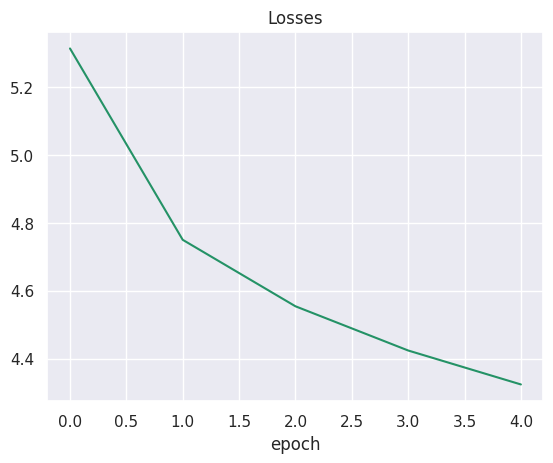

In [212]:
plt.plot(np.arange(len(losses)), [x.detach().cpu() for x in losses])
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

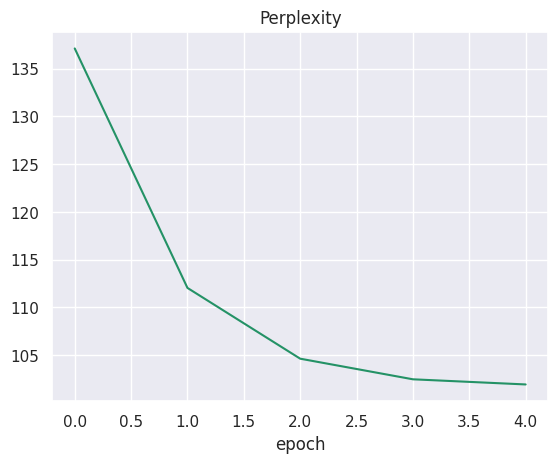

In [213]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [223]:
generate_sequence(model, starting_seq='I love to eat popcorn while')

'<bos> i love to eat popcorn while watching this movie <unk> <eos>'

In [215]:
generate_sequence(model, starting_seq='If you are angry you should')

'<bos> if you are angry you should see this movie <unk> <eos>'

#### Другой lr

In [216]:
model2 = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.005)

In [217]:
losses, perplexities = train_model(model2, criterion, optimizer, num_epoch=5)

Epoch 0:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 5.625980377197266, perplexity: 243.12789858304538


Epoch 1:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 5.3337602615356445, perplexity: 223.7559585571289


Epoch 2:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 5.244012832641602, perplexity: 214.24136460133087


Epoch 3:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 5.207960605621338, perplexity: 214.75011678842398


Epoch 4:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 5.186878681182861, perplexity: 213.8957274999374


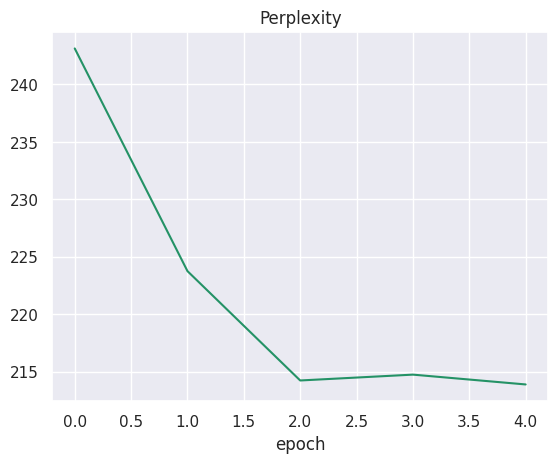

In [218]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [224]:
generate_sequence(model2, starting_seq='I love to eat popcorn while')

'<bos> i love to eat popcorn while <unk> <eos>'

In [225]:
generate_sequence(model2, starting_seq='If you are angry you should')

'<bos> if you are angry you should have a great job <unk> <eos>'

## Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

## GRU

In [262]:
class LanguageModelGRU(LanguageModel):
    def __init__(self, hidden_dim, vocab_size):
       # Опишите свою нейронную сеть здесь
        super().__init__(hidden_dim, vocab_size)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

model_GRU = LanguageModelGRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model_GRU.parameters(), lr = 0.001)

In [263]:
lossesGRU, perplexitiesGRU = train_model(model_GRU, criterion, optimizer, num_epoch=5)

Epoch 0:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 5.327377796173096, perplexity: 129.71745466574643


Epoch 1:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 4.704928398132324, perplexity: 105.56101437104054


Epoch 2:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 4.491446495056152, perplexity: 98.75706897637782


Epoch 3:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 4.34716796875, perplexity: 96.76099806565504


Epoch 4:   0%|          | 0/1243 [00:00<?, ?it/s]

avg_loss: 4.23480224609375, perplexity: 95.97358698722644


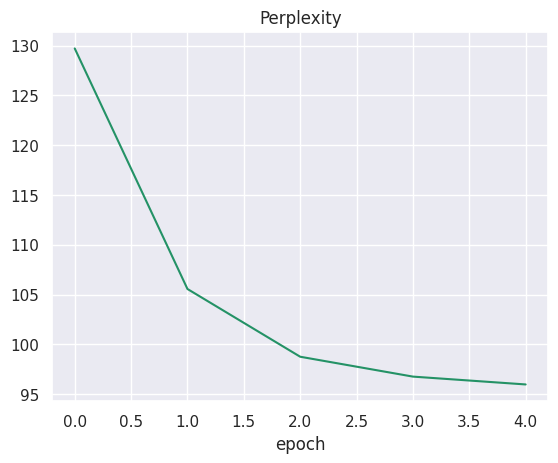

In [264]:
plt.plot(np.arange(len(perplexitiesGRU)), perplexitiesGRU)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [265]:
generate_sequence(model_GRU, starting_seq='I love to eat popcorn')

'<bos> i love to eat popcorn and i think it was a great movie <eos>'

In [266]:
generate_sequence(model_GRU, starting_seq='If you are angry you should')

'<bos> if you are angry you should have <unk> seen this movie <unk> <eos>'

# Попытка избавиться от пунктуации. Повторение формирования словаря и датасетов

In [133]:
import string

In [142]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for text in tqdm(dataset['train']['text']):

  sent_list = sent_tokenize(text.lower())
  for sent in sent_list:
    sent = sent.translate(
        str.maketrans('', '', string.punctuation))
    words = word_tokenize(sent)
    if 0 < len(words) < word_threshold:
            sentences.append(words)

# sentences - список предложений, где каждое предложение это список из слов

  0%|          | 0/25000 [00:00<?, ?it/s]

In [144]:
len(sentences)

214953

In [149]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
  for word in sentence:
    words[word] +=1

words_sorted = sorted(words.items(), key=lambda x: x[1], reverse=True)

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
for i in range(vocab_size):
  word, cnt = words_sorted[i]
  vocab.add(word)



  0%|          | 0/214953 [00:00<?, ?it/s]

In [151]:
words_sorted[:5]

[('the', 183155), ('a', 90414), ('and', 88118), ('of', 76297), ('to', 73031)]

In [152]:
len(vocab)

40004

In [167]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [168]:
for x in test_dataloader:
  print([ind2word[w.item()] for w in x['input_ids'][50]])
  break

['<bos>', 'i', 'liked', 'this', 'movie', 'sort', 'of', 'reminded', 'me', 'of', 'my', 'marriage', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


### Обучение базовой модели на данных без пунктуации

In [169]:
model_no_punkt = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model_no_punkt.parameters(), lr = 0.001)

In [170]:
losses, perplexities = train_model(model_no_punkt, criterion, optimizer, num_epoch=5)

Epoch 0:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 3.155608892440796, perplexity: 18.305030357270013


Epoch 1:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.7914936542510986, perplexity: 16.506067145438422


Epoch 2:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.6732656955718994, perplexity: 15.878379708244687


Epoch 3:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.5934255123138428, perplexity: 15.630795524233864


Epoch 4:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.5309438705444336, perplexity: 15.7151445434207


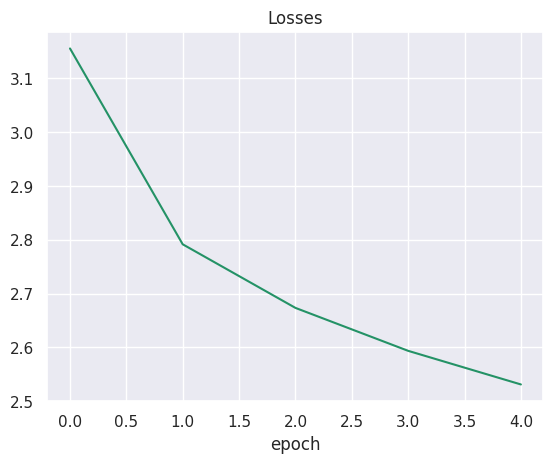

In [172]:
# plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(losses)), [x.detach().cpu() for x in losses])
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

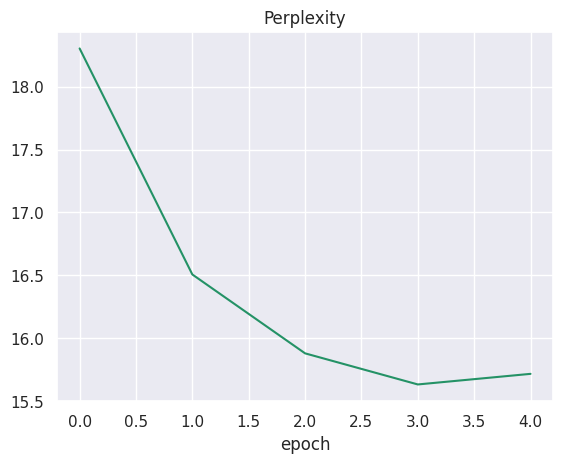

In [173]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [182]:
generate_sequence(model_no_punkt, starting_seq='I love to eat popcorn')

'<bos> i love to eat popcorn and watch it <eos>'

In [226]:
generate_sequence(model_no_punkt, starting_seq='I love to eat popcorn while')

'<bos> i love to eat popcorn while watching this movie <eos>'

In [191]:
generate_sequence(model_no_punkt, starting_seq='If you are angry you should')

'<bos> if you are angry you should see this movie <eos>'

## Третий эксперимент (GRU + без пунктуации)

In [188]:
class LanguageModelGRU(LanguageModel):
    def __init__(self, hidden_dim, vocab_size):
       # Опишите свою нейронную сеть здесь
        super().__init__(hidden_dim, vocab_size)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

In [189]:
model_np_GRU = LanguageModelGRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model_np_GRU.parameters(), lr = 0.001)

In [190]:
lossesGRU, perplexitiesGRU = train_model(model_np_GRU, criterion, optimizer, num_epoch=5)

Epoch 0:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 3.0849900245666504, perplexity: 17.27328091575986


Epoch 1:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.727841854095459, perplexity: 15.592258203597297


Epoch 2:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.604123592376709, perplexity: 15.069243680863153


Epoch 3:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.5172853469848633, perplexity: 14.971649896530877


Epoch 4:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.448463201522827, perplexity: 15.066011576425462


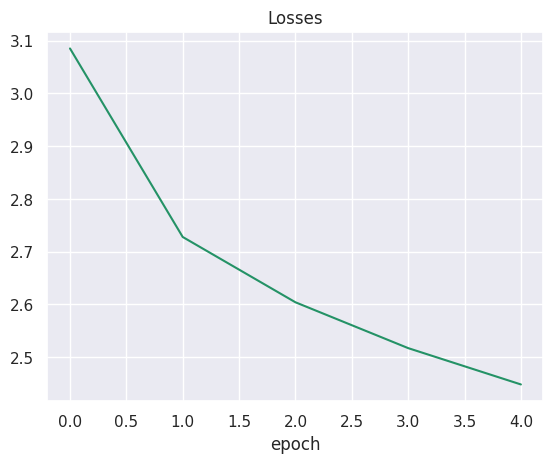

In [192]:
plt.plot(np.arange(len(lossesGRU)), [x.detach().cpu() for x in lossesGRU])
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

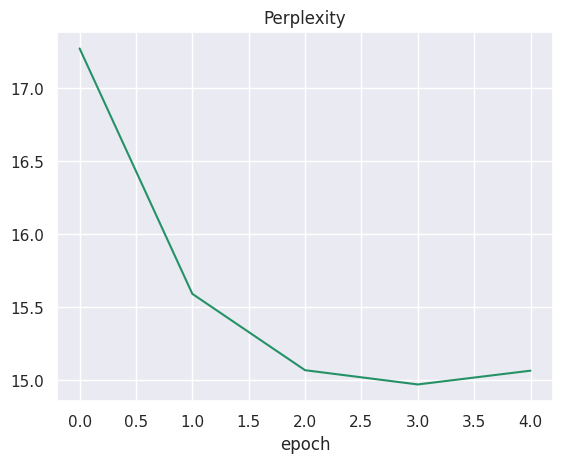

In [193]:
plt.plot(np.arange(len(perplexitiesGRU)), perplexitiesGRU)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [194]:
generate_sequence(model_np_GRU, starting_seq='I love to eat popcorn')

'<bos> i love to eat popcorn and i think it was a great movie <eos>'

In [229]:
generate_sequence(model_np_GRU, starting_seq='I love to eat popcorn while')

'<bos> i love to eat popcorn while watching this movie <eos>'

In [230]:
generate_sequence(model_np_GRU, starting_seq='If you are angry you should')

'<bos> if you are angry you should have to see a movie with a good idea <eos>'

## Четвёртый эксперимент (GRU 2 слоя + без пунктуации)

In [196]:
class LanguageModelGRU2(LanguageModel):
    def __init__(self, hidden_dim, vocab_size):
       # Опишите свою нейронную сеть здесь
        super().__init__(hidden_dim, vocab_size)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=2, batch_first=True)

In [197]:
model_np_GRU2 = LanguageModelGRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model_np_GRU2.parameters(), lr = 0.001)

In [199]:
lossesGRU, perplexitiesGRU = train_model(model_np_GRU2, criterion, optimizer, num_epoch=5)

Epoch 0:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 3.085064649581909, perplexity: 17.15354673635392


Epoch 1:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.724473714828491, perplexity: 15.533356308937073


Epoch 2:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.6012768745422363, perplexity: 15.064877873375302


Epoch 3:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.514916181564331, perplexity: 14.95299384139833


Epoch 4:   0%|          | 0/1344 [00:00<?, ?it/s]

avg_loss: 2.4465010166168213, perplexity: 15.051073999631972


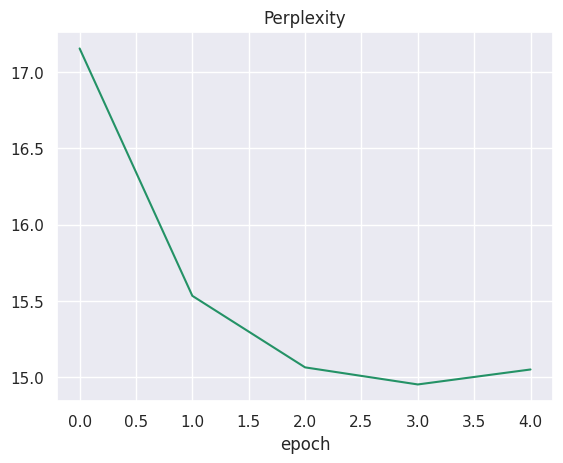

In [200]:
plt.plot(np.arange(len(perplexitiesGRU)), perplexitiesGRU)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [231]:
generate_sequence(model_np_GRU2, starting_seq='I love to eat popcorn')

'<bos> i love to eat popcorn <eos>'

In [233]:
generate_sequence(model_np_GRU2, starting_seq='I love to eat popcorn while')

'<bos> i love to eat popcorn while watching this movie <eos>'

In [202]:
generate_sequence(model_np_GRU2, starting_seq='If you are angry you should')

'<bos> if you are angry you should be disappointed <eos>'

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Проведённые эксперименты делятся на два блока: в первом на этапе препроцессинга в данных были оставлены знаки пунктуации, во втором - удалены.

Значения перплексии: </br>
Перплексия без удаления пунктуации:</br>
Базовая модель с семинара (lr=0.00) - 101</br>
Модель с семинара + lr=0.005 - 213</br>
Модель с семинара + GRU вместо стандартного слоя RNN - 95</br>
</br></br>
Перплексия с удалением пунктуации:</br>
Базовая модель с семинара - 15,6</br>
Модель с семинара + GRU вместо стандартного слоя RNN - 15,06</br>
Модель с семинара + GRU 2 слоя - 15,05</br>

На втором этапе значения перплекуии оказались на порядок ниже. Однако сравнение генеративных способностей показало, что прирост в качестве реботы данных моделей после удаления пунктуации уличшился не так значительно.

Кроме того, применение GRU слоя дало небольшой, но заметный прирост в качестве в обоих блоках.



Идеи по улучшению качества моделей: изменение гиперпараметров и архитектуры: как рекуррентных слоёв, так и линейных.
Кроме того, можно было увеличить объём данных, так как бОльшая часть корпуса отзывов исходного датасета в процессе работы использована не была

In [270]:
models = [model, model2, model_GRU, model_no_punkt, model_np_GRU, model_np_GRU2]
for modell in models:
  print('---')
  print(generate_sequence(modell, starting_seq='I love to eat popcorn'))
  print(generate_sequence(modell, starting_seq='I love to eat popcorn while'))
  print(generate_sequence(modell, starting_seq='If you are angry you should'))
  print(generate_sequence(modell, starting_seq='The movie was'))
  print(generate_sequence(modell, starting_seq='In my opinio  `n'))


---
<bos> i love to eat popcorn <unk> <eos>
<bos> i love to eat popcorn while watching this movie <unk> <eos>
<bos> if you are angry you should see this movie <unk> <eos>
<bos> the movie was a great movie <unk> <eos>
<bos> in my opinion <unk> the film is a great movie <unk> <eos>
---
<bos> i love to eat popcorn <unk> <eos>
<bos> i love to eat popcorn while <unk> <eos>
<bos> if you are angry you should have a great job <unk> <eos>
<bos> the movie was a great job <unk> <eos>
<bos> in my opinion <unk> <eos>
---
<bos> i love to eat popcorn <unk> <eos>
<bos> i love to eat popcorn while watching this movie <unk> <eos>
<bos> if you are angry you should have <unk> seen this movie <unk> <eos>
<bos> the movie was <unk> <unk> br <unk> <unk> <unk> br <unk> <unk> the movie is a good example of the film <unk> <eos>
<bos> in my opinion <unk> the movie is not a good <unk> <unk> <eos>
---
<bos> i love to eat popcorn and watch it <eos>
<bos> i love to eat popcorn while watching this movie <eos>
<bos> if